# Demos: Lecture 9

## Demo 1: Grover's algorithm

<img src="fig/grover_circuit_full_c.png" width="500px">

In [1]:
import pennylane as qml
import numpy as np

In [2]:
n_bits = 5
special_string = [1, 0, 0, 1, 1] 

dev = qml.device('default.qubit', wires=n_bits+1)

In [3]:
def hadamard_transform(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)

In [4]:
def oracle():
    qml.MultiControlledX(wires=range(n_bits + 1), control_values=special_string)

In [5]:
def diffusion():
    hadamard_transform(wires=list(range(n_bits)))
    qml.MultiControlledX(wires=range(n_bits + 1), control_values=[0]*n_bits)
    hadamard_transform(wires=list(range(n_bits)))

In [6]:
@qml.qnode(dev)
def grover(num_its):
    qml.PauliX(wires=n_bits)
    qml.Hadamard(wires=n_bits)
    hadamard_transform(wires=list(range(n_bits)))
    
    for _ in range(num_its):
        oracle()
        diffusion()
        
    return qml.probs(wires=range(n_bits))

For plotting after the implementation

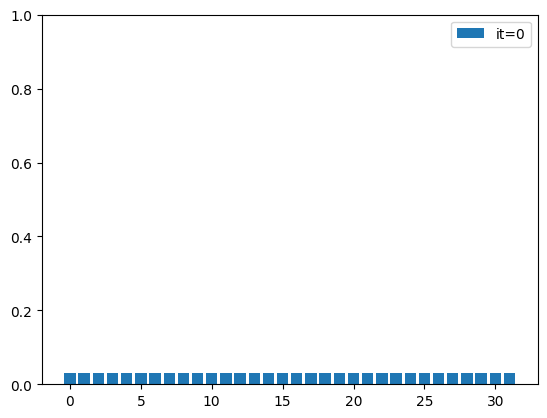

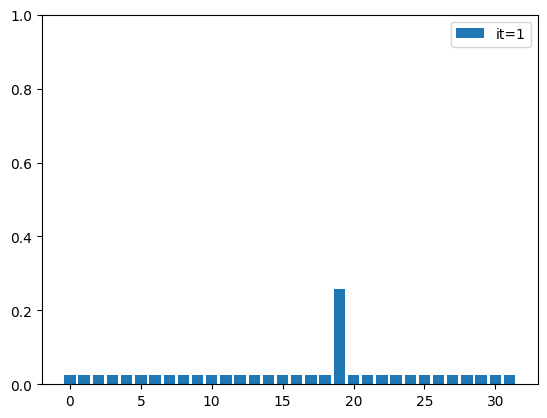

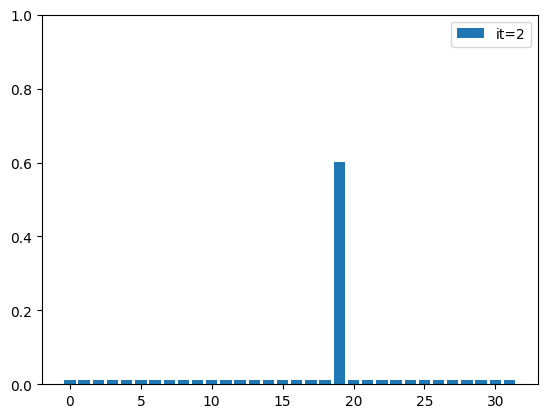

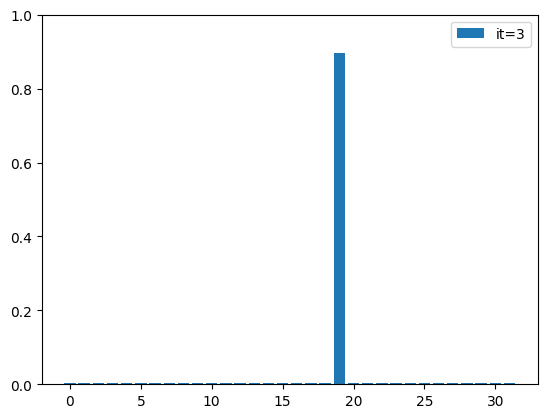

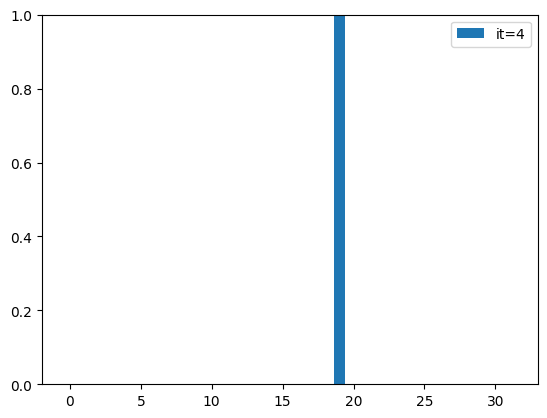

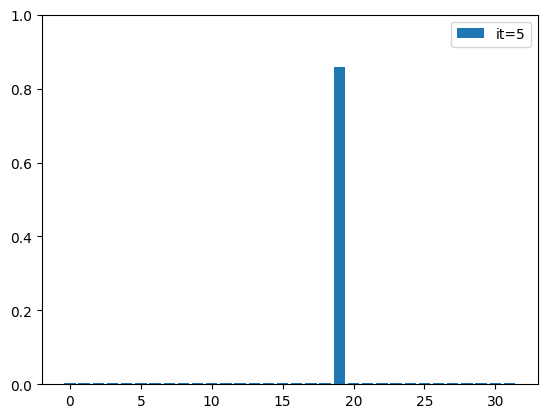

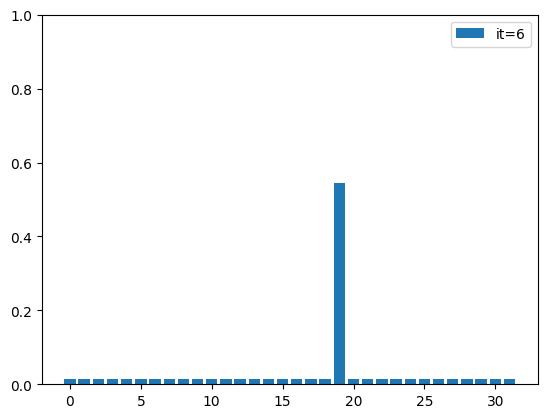

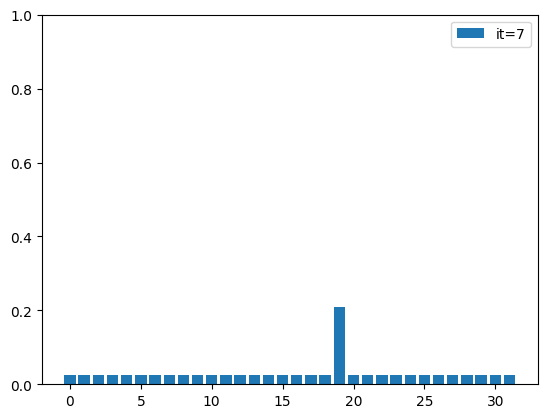

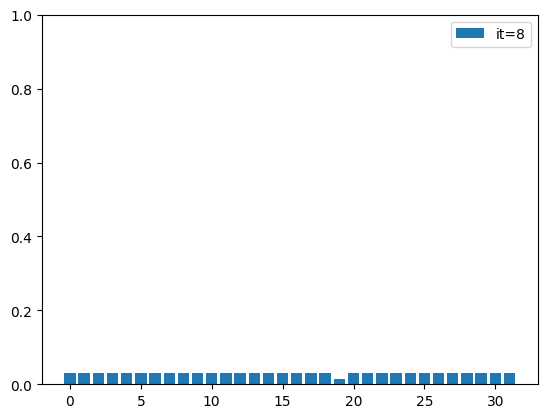

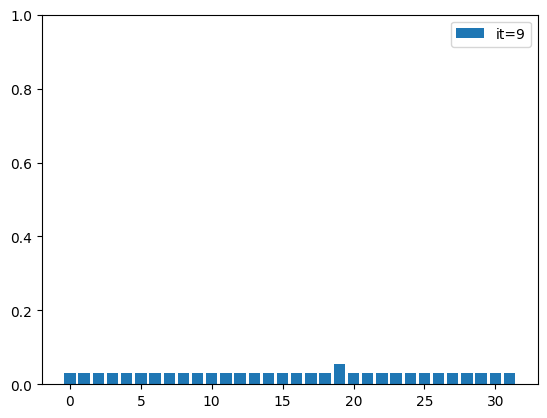

In [7]:
import matplotlib.pyplot as plt

for n in range(10):
    plt.bar(
        list(range(2 ** n_bits)),
        grover(num_its=n),
        label=f"it={n}"
    )
    plt.ylim(0, 1)
    plt.legend()
    plt.show()